# Project Briefing

## Dataset

The dataset consists of wine reviews from the website Wine Enthusiast. The data contains information such as the geographical origin, the variety, and  price of each wine. 
https://www.kaggle.com/zynicide/wine-reviews


## Objective

The objective is to see how well a Neural Network can predict the wine variety from the description provided by the reviewers.

# EDA

## Libraries

In [1]:
import pandas as pd
import numpy as np
import string
import re
from wordcloud import WordCloud
import tensorflow as tf
import pickle
import matplotlib.style as style
style.use('fivethirtyeight')
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from keras import models, layers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy import loadtxt
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA

import nltk
from nltk.collocations import * 
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


## Data Preparation and Visualization

## Wine Varieties

In [4]:
data = pd.read_csv('data\winemag-data-130k-v2.csv', index_col=0)
#data.dropna(inplace=True, subset=['description', 'variety'])
#data.drop_duplicates(subset=['description', 'variety'], keep='first', inplace=True)
#data.reset_index(drop=True, inplace=True)


#########
data2 = pd.read_csv('data\winemag-data_first150k.csv', index_col=0)
#data2.dropna(inplace=True), subset=['description', 'variety'])
#data2.drop_duplicates(subset=['description', 'variety'], keep='first', inplace=True)
#data2.reset_index(drop=True, inplace=True)

In [6]:
data2.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
df = pd.concat([data[['description', 'variety']], 
                  data2[['description', 'variety']]], axis=0)


df.drop_duplicates(keep='first', inplace=True)

In [4]:
df.head()

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169451 entries, 0 to 97829
Data columns (total 2 columns):
description    169451 non-null object
variety        169451 non-null object
dtypes: object(2)
memory usage: 3.9+ MB


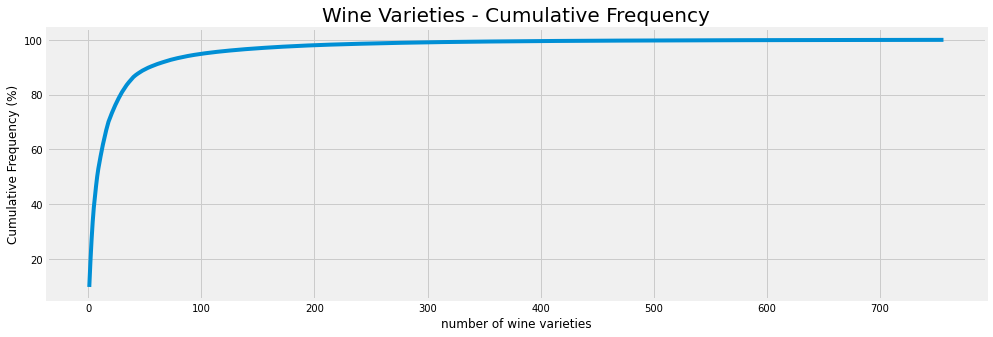

In [10]:
wine_varieties_df = pd.DataFrame(df['variety'].value_counts())

max_ = wine_varieties_df['variety'].cumsum().max()
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(wine_varieties_df.cumsum())+1), (wine_varieties_df['variety'].cumsum())/max_*100)
plt.xlabel('number of wine varieties')
plt.ylabel('Cumulative Frequency (%)')
plt.title('Wine Varieties - Cumulative Frequency', fontsize=20)
plt.show()



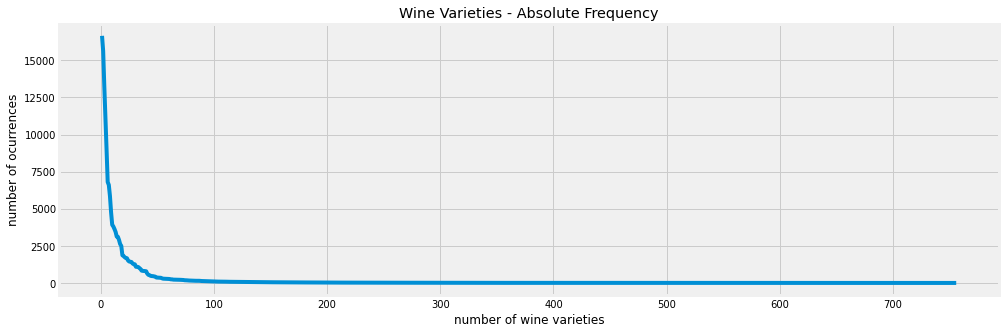

In [13]:
# 
y = wine_varieties_df
x = range(1, len(y)+1)


plt.figure(figsize=(15, 5))
plt.plot(x,
         y)
plt.xlabel('number of wine varieties')
plt.ylabel('number of ocurrences')
plt.title('Wine Varieties - Absolute Frequency')
plt.show()

n_top_100 = len(y)


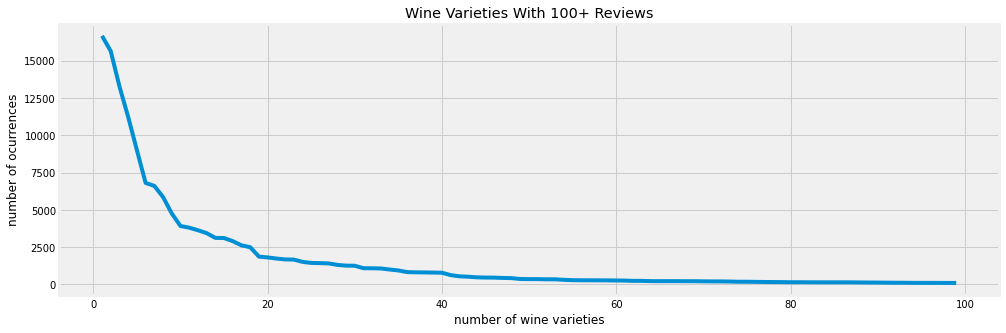

Wine Varieties with more then 100 reviews: 99


In [14]:
# 
y = wine_varieties_df[wine_varieties_df['variety'] > 100]
x = range(1, len(y)+1)


plt.figure(figsize=(15, 5))
plt.plot(x,
         y)
plt.xlabel('number of wine varieties')
plt.ylabel('number of ocurrences')
plt.title('Wine Varieties With 100+ Reviews')
plt.show()

n_top_100 = len(y)

print('Wine Varieties with more then 100 reviews:', n_top_100)

In [15]:
# top  varieties

above_100_varieties = wine_varieties_df.cumsum().nsmallest(n_top_100, 'variety').index



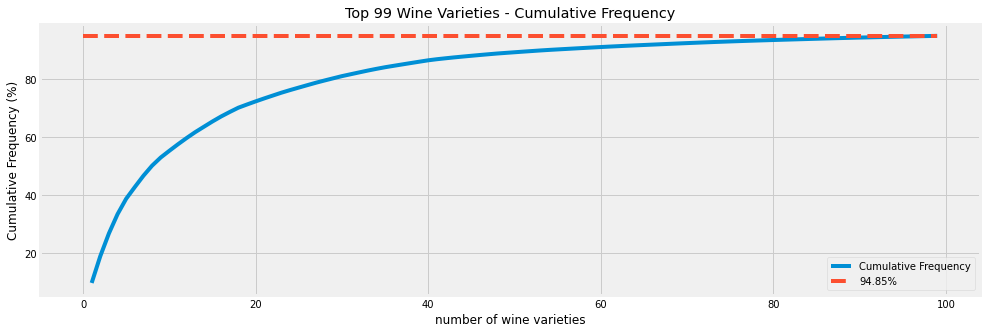

In [16]:
plt.figure(figsize=(15, 5))

x = range(1, n_top_100+1)
y = wine_varieties_df.cumsum().nsmallest(n_top_100, 'variety')/max_*100

plt.plot(x, 
         y,
         label='Cumulative Frequency'
        )
plt.xlabel('number of wine varieties')
plt.ylabel('Cumulative Frequency (%)')

plt.plot(range(0, n_top_100+1), 
         [y.max() for i in range(0, n_top_100+1)],
         label=str(round(y.max()[0], 2))+'%',linestyle='dashed'
         
        )



#plt.xticks(rotation=90)

plt.title('Top {} Wine Varieties - Cumulative Frequency'.format(n_top_100))


plt.legend()
plt.show()


# Data Trimming

## 100+ reviews only

In [10]:
# selecting only variaties with 100+ reviews

filt = [(wine not in above_100_varieties) for wine in data['variety']]
index_to_drop = data.loc[filt].index
data.drop(index=index_to_drop, inplace=True)


In [37]:
n_labels = len(data['variety'].unique())
wine_varieties = list(data['variety'].unique())

wine_varieties_df = pd.DataFrame(data['variety'].value_counts())



In [18]:
X = data['description']
y = data['variety'].astype('category')

lb = LabelBinarizer()
y = lb.fit_transform(y)

In [56]:
file = open('X.pickle', 'wb')
pickle.dump(X, file)

file = open('y.pickle', 'wb')
pickle.dump(y, file)

# Vectorization

## Exploratory Vectorization

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1988)
X_train_final, X_train_val, y_train_final, y_train_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1989)

In [23]:
# tokenize
pattern = "([A-Za-z]+-?'?[A-Za-z]+)"
texts_regex = [nltk.regexp_tokenize(text, pattern) for text in X]

# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

# Now we have a list that includes all english stopwords, ponctuation and wine varieties
stopwords_list += list(string.punctuation)
stopwords_list += wine_varieties

In [24]:
# TF IDF Vectorization
tfid_vectorizer = TfidfVectorizer(
    'content',
    token_pattern=pattern, # test without it
    #ngram_range=(1, 2),
    #max_df=0.10,
    #min_df=100,
    #min_df=50,
    stop_words=stopwords_list,
    max_features=None, # what is the ideal number here?
    )
tf_idf_vector = tfid_vectorizer.fit_transform(X)

idf_vector = tfid_vectorizer.idf_
vocabulary = tfid_vectorizer.vocabulary_
n_terms = tf_idf_vector.shape[-1]

C:\Users\felip\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abouriou', 'agiorgitiko', 'aglianico', 'aidani', 'airen', 'albana', 'albanello', 'albari', 'albarossa', 'aleatico', 'alejandr', 'alexandria', 'alfrocheiro', 'alicante', 'aligot', 'alkaras', 'alsace', 'altesse', 'alvarelh', 'alvarinho', 'alvarinho-chardonnay', 'amarela', 'angevine', 'ansonica', 'ant', 'apple', 'aragon', 'aragonez', 'argaman', 'arinto', 'arneis', 'asprinio', 'assyrtico', 'assyrtiko', 'athiri', 'austrian', 'auxerrois', 'avesso', 'azal', 'azkere', 'babi', 'babosa', 'bacchus', 'baco', 'baga', 'baga-touriga', 'barbera', 'barbera-nebbiolo', 'barroca', 'bastardo', 'bianca', 'biancale', 'bianco', 'biancolella', 'biancu', 'bical', 'black', 'blanc', 'blanc-assyrtiko', 'blanc-chardonnay', 'blanc-chenin', 'blanc-colombard', 'blanc-pinot', 'blanc-sauvignon', 'blanc-semi

### Exploratory Vocabulary 

After a initial vectorization and stopwords removal, the full vocabulary comes down to 40924 terms 


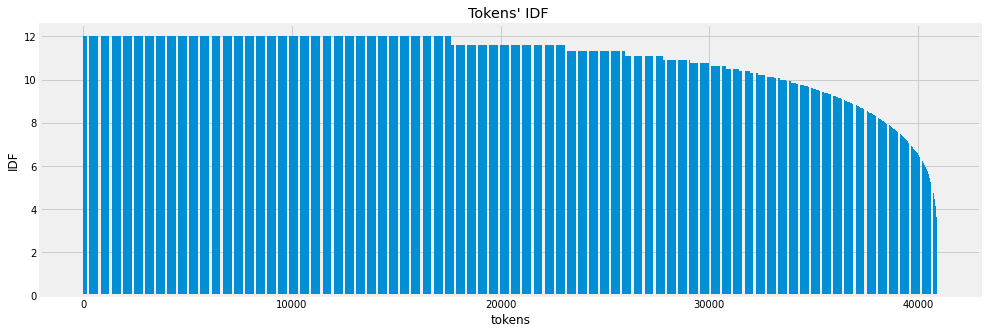

In [25]:
# how long is the vocabulary

print('After a initial vectorization and stopwords removal, the full vocabulary comes down to {} terms '.format(n_terms))


x = range(1,len(idf_vector)+1)
y = sorted(idf_vector, reverse=True)

plt.figure(figsize=(15, 5))
plt.bar(x, y)
plt.title("Tokens' IDF ")
plt.ylabel('IDF')
plt.xlabel('tokens')
plt.show()

The graph above indicates that the vast majority of terms appear only a handful of times throughout the corpus of wine descriptions. 

In limiting the number of features, the "min_df" parameter value should have a more significant impact then "max_df".  


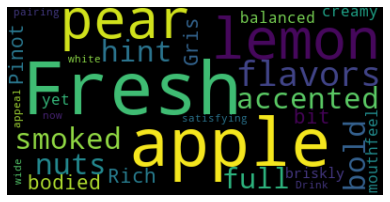

In [36]:

# one review:
text = data['description'][100]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Model Vectorization

In [17]:
# TF IDF Vectorization
tfid_vectorizer2 = TfidfVectorizer(
    'content',
    token_pattern=pattern, # test without it
    #ngram_range=(1, 2),
    #max_df=0.10,
    #min_df=100,
    min_df=10,
    stop_words=stopwords_list,
    #max_features=None, # what is the ideal number here?
    )
X_train_vectord2 = tfid_vectorizer2.fit(X_train)

X_train_final_vectord2 = tfid_vectorizer2.transform(X_train_final)
X_train_final_vectord2 = X_train_final_vectord2.toarray()

X_train_val_vectord2 = tfid_vectorizer2.transform(X_train_val)
X_train_val_vectord2 = X_train_val_vectord2.toarray()

X_test_vectord2  = tfid_vectorizer2.transform(X_test)
X_test_vectord2 = X_test_vectord2.toarray()


n_features2 = X_train_final_vectord2.shape[-1]

C:\Users\felip\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aglianico', 'albari', 'alvarinho', 'barbera', 'bianco', 'blanc', 'blaufr', 'blend', 'bonarda', 'bordeaux-style', 'cabernet', 'carmen', 'champagne', 'chardonnay', 'chenin', 'corvina', "d'avola", 'de', 'dolcetto', 'dre', 'falanghina', 'fiano', 'fino', 'franc', 'friulano', 'fum', 'g-s', 'gamay', 'garganega', 'garnacha', 'gew', 'glera', 'godello', 'gr', 'greco', 'grenache', 'grigio', 'grillo', 'gris', 'grosso', 'laurent', 'malbec', 'malbec-merlot', 'marsanne', 'mascalese', 'melon', 'menc', 'meritage', 'merlot', 'millon', 'molinara', 'monastrell', 'montepulciano', 'moscato', 'mourv', 'muscat', 'nacional', 'ne-style', 'nebbiolo', 'negroamaro', 'ner', 'nerello', 'nero', 'nkisch', 'noir', 'petit', 'petite', 'pinot', 'pinotage', 'port', 'portuguese', 'primitivo', 'prosecco', 'red',

# Prediction Model

### Neural Network

In [39]:
# Defines the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath='best_model_v2.h5', monitor='val_loss', save_best_only=True)]

# network architecture
model_1_v2 = models.Sequential()

# add layers 
# (in this case, Dense which means that this layer will be fully connected)
# input_shape parameter is often optiona
model_1_v2.add(layers.Dense(int(n_features2*0.9),#6000, 
                         kernel_initializer='lecun_normal',
                         activation='relu', 
                         input_shape=(n_features2,)))
model_1_v2.add(layers.Dropout(0.8))
model_1_v2.add(layers.Dense(int(n_features2*0.5), activation='relu'))
model_1_v2.add(layers.Dropout(0.8))
model_1_v2.add(layers.Dense(int(n_features2*0.2), activation='relu'))
model_1_v2.add(layers.Dropout(0.5))
model_1_v2.add(layers.Dense(n_labels, activation='softmax'))

# compile the model
model_1_v2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train the model
# batched size can be tuned. The model will forward and backwards propagate once per batch
history_1_v2 = model_1_v2.fit(X_train_final_vectord2, y_train_final,
                        epochs=50, batch_size=500,
                       validation_data=(X_train_val_vectord2, y_train_val),
                       class_weight='balanced',
                       callbacks=early_stopping)



Train on 67545 samples, validate on 11920 samples
Epoch 1/50
67545/67545 [==============================] - 521s 8ms/step - loss: 2.6892 - acc: 0.3349 - val_loss: 1.8030 - val_acc: 0.5226
Epoch 2/50
67545/67545 [==============================] - 550s 8ms/step - loss: 1.6996 - acc: 0.5405 - val_loss: 1.5144 - val_acc: 0.5905
Epoch 3/50
67545/67545 [==============================] - 564s 8ms/step - loss: 1.3323 - acc: 0.6317 - val_loss: 1.4414 - val_acc: 0.6029
Epoch 4/50
67545/67545 [==============================] - 575s 9ms/step - loss: 1.0782 - acc: 0.6964 - val_loss: 1.4402 - val_acc: 0.6089
Epoch 5/50
67545/67545 [==============================] - 549s 8ms/step - loss: 0.8725 - acc: 0.7481 - val_loss: 1.4736 - val_acc: 0.6102
Epoch 6/50
67545/67545 [==============================] - 558s 8ms/step - loss: 0.7174 - acc: 0.7901 - val_loss: 1.5347 - val_acc: 0.6086
Epoch 7/50
67545/67545 [==============================] - 558s 8ms/step - loss: 0.6050 - acc: 0.8190 - val_loss: 1.5745 - 

In [42]:
file = open('output.pickle', 'wb')
pickle.dump(dict(history_1_v2.history), file)

In [41]:
with open('output.pickle', 'rb') as f:
    history = pickle.load(f)

In [39]:
model_1_v2 = load_model('best_model_v2.h5')

In [43]:
model_1_v2.evaluate(X_test_vectord2, y_test)

34057/34057 [==============================] - 150s 4ms/step


[1.6600385066010792, 0.6144698593569372]

## Training Visualization

In [44]:
model_1_v2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6579)              48105648  
_________________________________________________________________
dropout_4 (Dropout)          (None, 6579)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3655)              24049900  
_________________________________________________________________
dropout_5 (Dropout)          (None, 3655)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1462)              5345072   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1462)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 99)                144837    
Total para

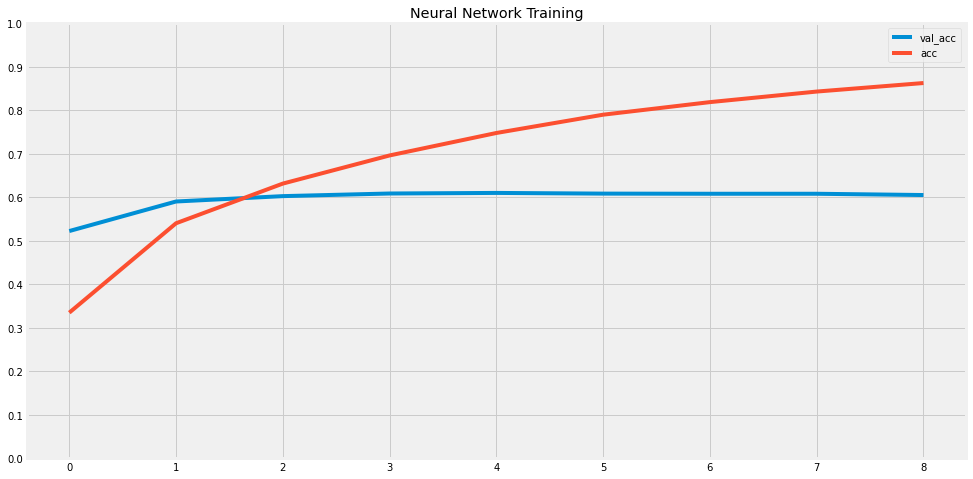

In [42]:
plt.figure(figsize=(15,8))
plt.plot(history['val_acc'], label='val_acc')
plt.plot(history['acc'], label='acc')
plt.title('Neural Network Training')
plt.yticks(np.linspace(0, 1, 11))
plt.legend()
plt.show()
